In [1]:
import os
import glob
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import shapely
import numpy as np
import altair as alt
import py3dep

In [2]:
sail_dl = [-106.987900, 38.956160]
sail_xband_radar = [-106.943140, 38.898361]
kettle_ponds = [-106.973006, 38.942005]
descriptions = ['Doppler Lidar (SAIL)', 'XBAND Radar (SAIL)', 'Kettle Ponds']


#Azimuth between SAIL DL and KPS: 140°35'31"

In [3]:
x_and_y =list(zip(*[
    sail_dl,
    sail_xband_radar,
    kettle_ponds
]))

gdf = gpd.GeoDataFrame(
    {
        'description' : 
        descriptions
    },
    geometry = gpd.points_from_xy(x_and_y[0], x_and_y[1])
)

gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('EPSG:32613')

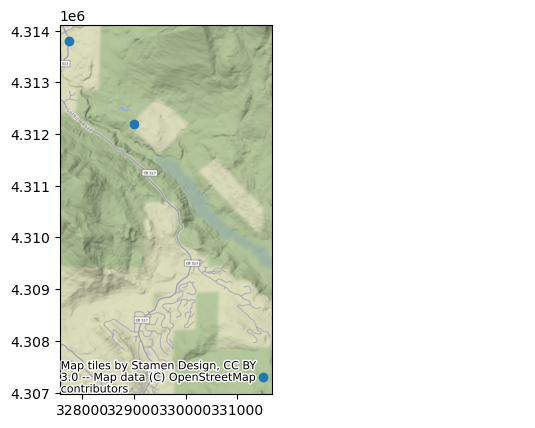

In [4]:
gdf.plot()
ctx.add_basemap(plt.gca(), crs=gdf.crs.to_string())

# Create lines

In [5]:
gdf

,description,geometry
0,Doppler Lidar (SAIL),POINT (327750.763 4313790.762)
1,XBAND Radar (SAIL),POINT (331492.737 4307292.350)
2,Kettle Ponds,POINT (329007.399 4312191.723)


In [6]:
lines_gdf = gpd.GeoDataFrame({
     'description': ['Doppler Lidar to KPS','XBAND Radar to KPS']
    },
    geometry = [
        shapely.geometry.LineString([
            gdf.loc[gdf['description'] == "Doppler Lidar (SAIL)", 'geometry'].iloc[0],
            gdf.loc[gdf['description'] == "Kettle Ponds", 'geometry'].iloc[0],
        ]), 
        shapely.geometry.LineString([
            gdf.loc[gdf['description'] == "XBAND Radar (SAIL)", 'geometry'].iloc[0],
            gdf.loc[gdf['description'] == "Kettle Ponds", 'geometry'].iloc[0],
        ]), 
    ]
)

In [7]:
lines_gdf = lines_gdf.set_crs(gdf.crs)

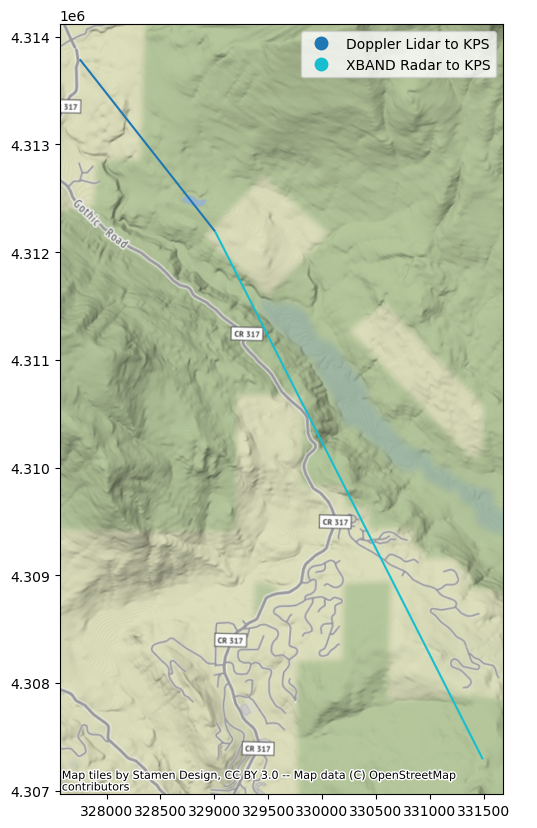

In [8]:
lines_gdf.plot(column='description', figsize=(10,10), legend=True)
ctx.add_basemap(plt.gca(), crs=gdf.crs.to_string())

In [9]:
lines_gdf

,description,geometry
0,Doppler Lidar to KPS,"LINESTRING (327750.763 4313790.762, 329007.399..."
1,XBAND Radar to KPS,"LINESTRING (331492.737 4307292.350, 329007.399..."


In [10]:
elevation1 = py3dep.elevation_profile(lines_gdf.geometry.iloc[0], spacing=10, crs=lines_gdf.crs)
elevation2 = py3dep.elevation_profile(lines_gdf.geometry.iloc[1], spacing=10, crs=lines_gdf.crs)

In [11]:
alt.Chart(elevation1.to_dataframe().reset_index()).mark_area().encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y('elevation', title='Elevation/Altitude (m)', scale=alt.Scale(zero=False, domain = [2750, 3200]))
).properties(width=500) & \
alt.Chart(elevation2.to_dataframe().reset_index()).mark_area().encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y('elevation', title='Elevation/Altitude (m)', scale=alt.Scale(zero=False, domain = [2750, 3500]))
).properties(width=500)

/Users/elischwat/mambaforge/envs/arm/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

# Find elevation difference between XBand RADAR and KPS

In [12]:
elevation2_df = elevation2.to_dataframe().reset_index()
elevation2_df['elevation'].iloc[0] - elevation2_df['elevation'].iloc[-1]

277.3003011327073

# Find obstruction angle for the Doppler LIDAR

In [13]:
elevation1_df = elevation1.to_dataframe().reset_index()

In [14]:
elevation1_df.head()

,z,spatial_ref,x,y,distance,elevation
0,0,0,327756.861397,4.313783e+06,9.989057,2886.260239
1,1,0,327763.021336,4.313775e+06,19.978114,2886.660851
2,2,0,327769.181275,4.313767e+06,29.967172,2886.582275
3,3,0,327775.341214,4.313759e+06,39.956229,2886.496368
4,4,0,327781.501154,4.313752e+06,49.945286,2886.594635


In [15]:
# Find angle from the Doppler lidar to all points along topography towards Kettle Ponds

# identify Doppler LIDAR distance value
    ## NOTE: NOT SURE THIS IS THE RIGHT LOCATION??
dl_location = elevation1_df.iloc[0] 
# identify Doppler LIDAR and KPS elevation values
dl_elevation = elevation1_df.iloc[0]['elevation']
kps_elevation = elevation1_df.iloc[-1]['elevation']

# identify distance between Doppler LIDAR and KPS
distance_between_dl_and_kps = elevation1_df['distance'].max()

elevation1_df['elevation_angle_from_dl'] = elevation1_df.apply(
    lambda row: np.rad2deg(np.arctan(
        (row['elevation'] - dl_location['elevation']) / (row['distance'] - dl_location['distance'])
    )), 
    axis=1
)

# Find lowest measurement height above Doppler lidar location assuming each maximum is THE obstructing maximum
elevation1_df['lowest_measurement_height'] = elevation1_df.apply(
    lambda row: distance_between_dl_and_kps*np.tan(np.deg2rad(row['elevation_angle_from_dl'])) + (dl_elevation - kps_elevation),
    axis = 1
)

/var/folders/jy/xv6qnlms2cj_3p5yrzcwc0n00000gn/T/ipykernel_22612/3715553969.py:15: RuntimeWarning: invalid value encountered in double_scalars
  (row['elevation'] - dl_location['elevation']) / (row['distance'] - dl_location['distance'])


In [16]:
most_obstructing_points_df = elevation1_df.sort_values('elevation_angle_from_dl', ascending=False).head(10)
most_obstructing_point_df = elevation1_df.sort_values('elevation_angle_from_dl', ascending=False).head(1)

In [17]:
alt.Chart(elevation1_df).mark_area().encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y('elevation', title='Elevation/Altitude (m)', scale=alt.Scale(zero=False, domain = [2850, 3000]))
).properties(width=1000) + alt.Chart(most_obstructing_points_df).mark_point(color='orange').encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y('elevation', title='Elevation/Altitude (m)', scale=alt.Scale(zero=False, domain = [2850, 3000]))
).properties(width=1000) + alt.Chart(most_obstructing_point_df).mark_point(color='red').encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y('elevation', title='Elevation/Altitude (m)', scale=alt.Scale(zero=False, domain = [2850, 3000]))
).properties(width=1000)

/Users/elischwat/mambaforge/envs/arm/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [18]:
most_obstructing_point_df

,z,spatial_ref,x,y,distance,elevation,elevation_angle_from_dl,lowest_measurement_height
11,11,0,327824.682342,4.313697e+06,119.968577,2902.120221,8.205967,320.467058
